In [5]:
%pip install ipynb

# Run the above line to get the preprocess() function from Preprocessing.ipynb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from ipynb.fs.full.Preprocessing import preprocess


In [3]:
def label_corrector(array):
    temp = list()
    seen_labels = set()
    dict_of_labels = dict()
    label_counter = -1
    for label in array:
        if label in seen_labels:
            temp.append(dict_of_labels[label])
        else:
            label_counter += 1
            dict_of_labels[label] = label_counter
            seen_labels.add(label)
            temp.append(label_counter)
    return np.array(temp)

def k_fold_preprocess(row_count=100000, k=10):
    """
    Splits the dataset into k groups
    
    Output: [ ((validation_1_x, validation_1_y), (training_1_x, training_1_y)),
              ((validation_2_x, validation_2_y), (training_2_x, training_2_y)),
              ...
              ((validation_k_x, validation_k_y), (training_k_x, training_k_y))]
    """
    df = pd.read_csv('star_classification.csv')
    df.drop(['obj_ID'], axis = 1,inplace=True) #dropping OBJ_ID feature as it is just the ID
    df.drop(['rerun_ID'], axis = 1,inplace=True)#dropping rerun_ID feature as it is the same for all
    df.drop(['run_ID'], axis = 1,inplace=True)
    df.drop(['field_ID'], axis = 1,inplace=True)
    df.drop(['spec_obj_ID'], axis = 1,inplace=True)
    
    data = np.array(df)
    class_index = 8
    data[:,class_index] = label_corrector(data[:,class_index])
    
    complete_x = np.concatenate((data[:,:class_index],data[:,class_index+1:]),axis=1)
    complete_y = data[:,class_index]
    
    # Remove outliers from the dataset
    tdata = np.transpose(complete_x)
    
    IQRs = list()
    outlier_rows = np.array([])
    for ind, col in  enumerate(tdata):
        if ind in [3,4,5,6,2]:
            percentiles = np.percentile(col,[25,75])
            IQR = percentiles[1]-percentiles[0]
            right = (col>percentiles[1]+1.5*IQR)*1
            left = (col < (percentiles[0]-1.5*IQR))*1
            outliers = right+left
            #print(f"{ind}th feature has {sum(outliers)} outliers.")
            outlier_rows = np.append(outlier_rows,np.where(outliers == 1)[0])
            
    outlier_rows = np.array(list(set(outlier_rows)))
    outlier_rows = np.array(outlier_rows,dtype = 'int')
    
    complete_x = np.delete(complete_x,outlier_rows,axis=0)
    complete_y = np.delete(complete_y,outlier_rows,axis=0)
    
    # Standardize the dataset
    means_x = list()
    stds_x = list()

    for ind in range(np.shape(complete_x)[1]):
        col = complete_x[:,ind]
        mean = np.mean(col)
        std = np.std(col)
        means_x.append(mean)
        stds_x.append(std)
        complete_x[:,ind] = (col-mean)/std
        
    """
    Splits the dataset into k groups
    
    Output: [ ((validation_1_x, validation_1_y), (training_1_x, training_1_y)),
              ((validation_2_x, validation_2_y), (training_2_x, training_2_y)),
              ...
              ((validation_k_x, validation_k_y), (training_k_x, training_k_y))]
    """
        
    folds = []
    fold_size = complete_x.shape[0] // k
    prev_index = 0
    for i in range(k):
        validation_x = complete_x[prev_index:prev_index + fold_size]
        validation_y = complete_y[prev_index:prev_index + fold_size]
        
        training_x = np.concatenate((complete_x[0:prev_index], complete_x[prev_index+fold_size:]), axis=0)
        training_y = np.concatenate((complete_y[0:prev_index], complete_y[prev_index+fold_size:]), axis=0)
        
        folds.append( ((validation_x, validation_y), (training_x, training_y)) )
        prev_index += fold_size
        
        
    return folds

In [4]:
def LogisticRegressionTrain(train_x, train_y, lr=0.5):
    number_of_classes = 3
    number_of_features = train_x.shape[1]
    number_of_samples = train_x.shape[0]
    learning_rate = lr
    
    assert(number_of_features == 12)
    
    # One-hot encode the classes for training
    # E.g., if class array is [0, 0, 1, 0, 2]
    # Convert to [[1,0,0], [1,0,0], [0,1,0], [1,0,0],[0,0,1]]
    one_hot_encoded = []

    for arr in (train_y):
        if (arr == [0]):
            one_hot_encoded.append([1, 0, 0,])
        elif (arr == [1]):
            one_hot_encoded.append([0, 1, 0,])
        elif (arr == [2]):
            one_hot_encoded.append([0, 0, 1,])
        else:
            print("error")

    encoded_train_y = np.array(one_hot_encoded)

    # Initialize the weights
    weights = np.random.rand(number_of_features, number_of_classes)
    bias = np.random.randn(1, number_of_classes)
    
    iteration_count = 1000
    for i in range(1, iteration_count + 1):
        # Get the Log-odds (logit)
        logits = train_x @ weights + bias

        # Calculate the probability of y 
        # Pr(Y = 0, 1, or 2 | X = train_x)
        max_value = np.max(logits, axis =1, keepdims=True)
        numerator = np.exp(logits - max_value)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        y_probability = numerator / denominator
                
        # Calculate the gradient vectors 
        
        # Gradient of the weights
        dW = (1 / number_of_samples) * (train_x.T @ (y_probability - encoded_train_y))
        
        # Gradient of the bias
        db = (1 / number_of_samples) * np.sum((y_probability - encoded_train_y), axis=0, keepdims=True)
        
        # We use gradient descent to update the weights and bias because
        # the number of samples is quite high. If we had used Newton-Raphson 
        # method, we would have had to compute the inverse of 100,000x100,000
        # matrix which is impossible due to hardware insufficiencies.
        weights -= (dW * learning_rate)
        bias -= (db * learning_rate)
        
    return weights, bias
        

    

In [5]:
def make_prediction(feature, weights, bias, threshold=0.5):
    logits = feature @ weights + bias

    max_value = np.max(logits, axis =1, keepdims=True)
    numerator = np.exp(logits - max_value)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    y_probability = numerator / denominator
    
    return np.argmax(y_probability, axis=1)

In [6]:
import seaborn as sn

def confusion_matrix(test_x, test_y, weights, bias, verbose=False):
    prediction = make_prediction(test_x, weights, bias)    
    confusion_matrix = np.zeros((3, 3), dtype=int)
    
    accurate_prediction_count = 0
    for i, pred in enumerate(prediction):
        if test_y[i][0] == 0:
            if pred == 0: 
                confusion_matrix[0][0] += 1
            elif pred == 1:
                confusion_matrix[0][1] += 1
            elif pred == 2:
                confusion_matrix[0][2] += 1
        
        elif test_y[i][0] == 1:
            if pred == 0:
                confusion_matrix[1][0] += 1
            elif pred == 1:
                confusion_matrix[1][1] += 1
            elif pred == 2:
                confusion_matrix[1][2] += 1
                
        elif test_y[i][0] == 2:
            if pred == 0:
                confusion_matrix[2][0] += 1
            elif pred == 1:
                confusion_matrix[2][1] += 1
            elif pred == 2:
                confusion_matrix[2][2] += 1
        
        if pred == test_y[i][0]:
            accurate_prediction_count += 1
            
    
    if verbose:
        s = sn.heatmap(confusion_matrix, annot=True, fmt='g')
        s.set(xlabel='Predicted Labels', ylabel='True Labels')
        plt.show()
    return accurate_prediction_count / test_y.shape[0] * 100 
        


### Tuning the learning rate K-Fold cross validation

In [8]:
"""
    Splits the dataset into k groups
    
    Output: [ ((validation_1_x, validation_1_y), (training_1_x, training_1_y)),
              ((validation_2_x, validation_2_y), (training_2_x, training_2_y)),
              ...
              ((validation_k_x, validation_k_y), (training_k_x, training_k_y))]
"""
k = 10
folds = k_fold_preprocess(100000, 10)
best_accuracy = 0

learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.7]
average_accuracies = []

for lr in learning_rates:   
    acc_rate = 0
    for ind in range(k):
        validation_x = folds[ind][0][0]
        validation_y = folds[ind][0][1]

        training_x = folds[ind][1][0]
        training_y = folds[ind][1][1]

        training_y = training_y.reshape(-1, 1)
        training_y = training_y.astype('int')

        training_x = training_x.astype('float')
        validation_x = validation_x.astype('float')

        validation_y = validation_y.reshape(-1, 1)
        validation_y = validation_y.astype('int')

        weights, bias = LogisticRegressionTrain(training_x, training_y, lr=lr)
        acc = confusion_matrix(validation_x, validation_y, weights, bias)
        
        print(f"Validation accuracy on fold {ind} when learning rate = {lr}: {acc}")
        
        acc_rate += acc
    average_accuracies.append(acc_rate / k)
    print(f"Average accuracy when learning rate is {lr}: {acc_rate / k}")
    print("\n\n")

Validation accuracy on fold 0 when learning rate = 0.0001: 51.15461847389559
Validation accuracy on fold 1 when learning rate = 0.0001: 55.16064257028113
Validation accuracy on fold 2 when learning rate = 0.0001: 21.997991967871485
Validation accuracy on fold 3 when learning rate = 0.0001: 26.556224899598398
Validation accuracy on fold 4 when learning rate = 0.0001: 34.78915662650602
Validation accuracy on fold 5 when learning rate = 0.0001: 59.27710843373494
Validation accuracy on fold 6 when learning rate = 0.0001: 10.522088353413654
Validation accuracy on fold 7 when learning rate = 0.0001: 13.94578313253012
Validation accuracy on fold 8 when learning rate = 0.0001: 56.5863453815261
Validation accuracy on fold 9 when learning rate = 0.0001: 29.136546184738954
Average accuracy when learning rate is 0.0001: 35.912650602409634



Validation accuracy on fold 0 when learning rate = 0.001: 41.40562248995984
Validation accuracy on fold 1 when learning rate = 0.001: 60.21084337349397
Valida

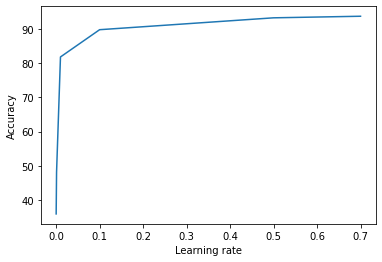

In [9]:
plt.plot(learning_rates, average_accuracies)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.show()